In [1]:
import os
import shutil
import stat
import seaborn as sns
import collections
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.image as img
import random
import cv2
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as img
from os import listdir
from os.path import isfile, join
from collections import defaultdict
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from sklearn.model_selection import train_test_split
from skimage.io import imread
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend 
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models

In [3]:
def gen_train_test_split(image_dir, target_dir, train_ratio=0.75):
    # Eğer hedef dizin yoksa oluştur
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    train_dir = os.path.join(target_dir, 'train')
    test_dir = os.path.join(target_dir, 'test')
    
    # Eğer eğitim ve test dizinleri yoksa oluştur
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
    
    # Görüntü dosyalarını ve sınıfları yükle
    all_classes = os.listdir(image_dir)
    for class_name in all_classes:
        class_dir = os.path.join(image_dir, class_name)
        all_images = os.listdir(class_dir)
        num_images = len(all_images)
        
        # Eğitim ve test örneklerini rastgele seç
        num_train_samples = int(train_ratio * num_images)
        train_samples_selected = random.sample(all_images, num_train_samples)
        test_samples_selected = [img for img in all_images if img not in train_samples_selected]
        
        # Eğitim örneklerini kopyala
        for train_img in train_samples_selected:
            src_train = os.path.join(class_dir, train_img)
            dest_train = os.path.join(train_dir, class_name, train_img)
            if not os.path.exists(os.path.join(train_dir, class_name)):
                os.makedirs(os.path.join(train_dir, class_name))
            shutil.copy(src_train, dest_train)
        
        # Test örneklerini kopyala
        for test_img in test_samples_selected:
            src_test = os.path.join(class_dir, test_img)
            dest_test = os.path.join(test_dir, class_name, test_img)
            if not os.path.exists(os.path.join(test_dir, class_name)):
                os.makedirs(os.path.join(test_dir, class_name))
            shutil.copy(src_test, dest_test)

# Görüntü dizini
image_dir = r"C:\Users\kurt_\Desktop\food-101\images"
# Hedef dizin
target_dir = r"C:\Users\kurt_\Desktop\food-101"

# Eğitim ve test örneği oranı
train_ratio = 0.75

# Train ve test setlerini oluştur
gen_train_test_split(image_dir, target_dir, train_ratio)

In [4]:
# Method to load train-test files.
def load_train_test_data(path_to_train_imgs, path_to_test_imgs):
    X_train, y_train = load_images(path_to_train_imgs)
    X_test, y_test = load_images(path_to_test_imgs)
    return X_train, y_train, X_test, y_test

# Generate train-test files. 
if not os.path.isdir("C:/Users/kurt_/Desktop/food-101/test") and not os.path.isdir("C:/Users/kurt_/Desktop/food-101/train"):
    gen_train_test_split()  
    len_train = len(os.listdir("C:/Users/kurt_/Desktop/food-101/train"))
    len_test = len(os.listdir("C:/Users/kurt_/Desktop/food-101/test"))
    print(len_train, len_test)
else:
    print('train and test folders already exist.')
    len_train = len(os.listdir("C:/Users/kurt_/Desktop/food-101/train"))
    len_test = len(os.listdir("C:/Users/kurt_/Desktop/food-101/test"))
    print(len_train, len_test)

train and test folders already exist.
101 101


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LambdaCallback
from tensorflow.keras import regularizers

import tensorflow.keras.backend as K

# Clear Keras session
K.clear_session()

# Define constants
n_classes = 101
batch_size = 16
width, height = 299, 299
train_data = r"C:\Users\kurt_\Desktop\food-101\train"
test_data = r"C:\Users\kurt_\Desktop\food-101\test"
train_samples = 75750
test_samples = 25250

# Data generators
train_data_gen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1. / 255)
train_gen = train_data_gen.flow_from_directory(train_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')
test_gen = test_data_gen.flow_from_directory(test_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

# Model
inception = InceptionV3(weights='imagenet', include_top=False)
layer = inception.output
layer = GlobalAveragePooling2D()(layer)
layer = Dense(128, activation='relu')(layer)
layer = Dropout(0.2)(layer)
predictions = Dense(n_classes, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(layer)
model = Model(inputs=inception.input, outputs=predictions)

# Compile model
optimizer = SGD(momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpointer = ModelCheckpoint(filepath='best_model_101class_inceptionv3den4.hdf5', save_best_only=True)
csv_logger = CSVLogger('history_101class_inceptionv3den4.log')

# Progress print callback
def print_progress(epoch, logs):
    print("Epoch {}, Loss: {:.4f}, Accuracy: {:.4f}, Val Loss: {:.4f}, Val Accuracy: {:.4f}".format(
        epoch+1, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']))

progress_printer = LambdaCallback(on_epoch_end=print_progress)

# Train the model
history_101class_inceptionv3den4 = model.fit(train_gen, 
                             steps_per_epoch=train_samples // batch_size, 
                             validation_data=test_gen, 
                             validation_steps=test_samples // batch_size, 
                             epochs=30, 
                             callbacks=[csv_logger, checkpointer, progress_printer])

# Save the model
model.save('model_trained_101class_inceptionv3den4.hdf5')


Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
Epoch 1/30
4734/4734 [==============================] - 1919s 403ms/step - loss: 3.2059 - accuracy: 0.2871 - val_loss: 2.8070 - val_accuracy: 0.3874
Epoch 2/30
4734/4734 [==============================] - 1380s 291ms/step - loss: 2.4135 - accuracy: 0.4620 - val_loss: 2.2153 - val_accuracy: 0.5213
Epoch 3/30
4734/4734 [==============================] - 1331s 281ms/step - loss: 2.1082 - accuracy: 0.5424 - val_loss: 1.9947 - val_accuracy: 0.5888
Epoch 4/30
4734/4734 [==============================] - 1342s 283ms/step - loss: 1.8996 - accuracy: 0.5924 - val_loss: 2.2994 - val_accuracy: 0.5305
Epoch 5/30
4734/4734 [==============================] - 1324s 280ms/step - loss: 1.7539 - accuracy: 0.6266 - val_loss: 1.7838 - val_accuracy: 0.6325
Epoch 6/30
4734/4734 [==============================] - 1321s 279ms/step - loss: 1.6253 - accuracy: 0.6598 - val_loss: 1.9617 - val_accuracy: 0.6238
Epoch 7/30
4734/

In [3]:
model_path = r"C:\Users\kurt_\best_model_101class_inceptionv3den4.hdf5"
test_data_path = r"C:\Users\kurt_\Desktop\food-101\test"

In [4]:
# Performans metriklerini hesaplamak için fonksiyon tanımla
def calculate_metrics(model, test_gen):
    # Modelden tahminler yap
    predictions = model.predict(test_gen)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Gerçek sınıfları al
    true_classes = test_gen.classes
    
    # Sınıf etiketlerini al
    class_labels = list(test_gen.class_indices.keys())

    # Doğruluk, hassasiyet, geri çağırma ve F1 puanını hesapla
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    f1 = f1_score(true_classes, predicted_classes, average='weighted')

    return accuracy, precision, recall, f1

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from keras.models import load_model
import numpy as np


# Boyutları tanımla
height, width = 299, 299

# Batch boyutunu tanımla
batch_size = 16

# Test veri üreteci oluştur
test_data_gen = ImageDataGenerator(rescale=1. / 255)
test_gen = test_data_gen.flow_from_directory(test_data_path, target_size=(height, width), batch_size=batch_size, class_mode='categorical', shuffle=False)

# Modeli yükle
model = load_model(model_path, compile=False)

# Performans metriklerini hesapla
accuracy, precision, recall, f1_score = calculate_metrics(model, test_gen)

# Hesaplanan metrikleri yazdır
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Found 25250 images belonging to 101 classes.
1579/1579 [==============================] - 91s 57ms/step
Accuracy: 0.7588118811881188
Precision: 0.7796338410602628
Recall: 0.7588118811881188
F1 Score: 0.7583170609515716


1/1 [==============================] - 1s 1s/step


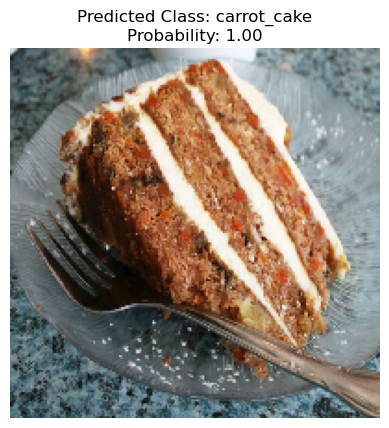

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Modeli yükleyin
model_path = r"C:\Users\kurt_\best_model_101class_inceptionv3den4.hdf5"
model = load_model(model_path, compile=False)

# Test edilecek resmin yolu
image_path = r"C:\Users\kurt_\Desktop\food-101\test\carrot_cake\3568676.jpg"
# Sınıf etiketlerini ve indekslerini içeren sözlük
class_map = {
    0: 'apple_pie', 1: 'baby_back_ribs', 2: 'baklava', 3: 'beef_carpaccio', 4: 'beef_tartare',
    5: 'beet_salad', 6: 'beignets', 7: 'bibimbap', 8: 'bread_pudding', 9: 'breakfast_burrito',
    10: 'bruschetta', 11: 'caesar_salad', 12: 'cannoli', 13: 'caprese_salad', 14: 'carrot_cake',
    15: 'ceviche', 16: 'cheesecake', 17: 'cheese_plate', 18: 'chicken_curry', 19: 'chicken_quesadilla',
    20: 'chicken_wings', 21: 'chocolate_cake', 22: 'chocolate_mousse', 23: 'churros', 24: 'clam_chowder',
    25: 'club_sandwich', 26: 'crab_cakes', 27: 'creme_brulee', 28: 'croque_madame', 29: 'cup_cakes',
    30: 'deviled_eggs', 31: 'donuts', 32: 'dumplings', 33: 'edamame', 34: 'eggs_benedict', 35: 'escargots',
    36: 'falafel', 37: 'filet_mignon', 38: 'fish_and_chips', 39: 'foie_gras', 40: 'french_fries', 
    41: 'french_onion_soup', 42: 'french_toast', 43: 'fried_calamari', 44: 'fried_rice', 45: 'frozen_yogurt',
    46: 'garlic_bread', 47: 'gnocchi', 48: 'greek_salad', 49: 'grilled_cheese_sandwich', 50: 'grilled_salmon',
    51: 'guacamole', 52: 'gyoza', 53: 'hamburger', 54: 'hot_and_sour_soup', 55: 'hot_dog', 56: 'huevos_rancheros',
    57: 'hummus', 58: 'ice_cream', 59: 'lasagna', 60: 'lobster_bisque', 61: 'lobster_roll_sandwich', 62: 'macaroni_and_cheese',
    63: 'macarons', 64: 'miso_soup', 65: 'mussels', 66: 'nachos', 67: 'omelette', 68: 'onion_rings', 69: 'oysters',
    70: 'pad_thai', 71: 'paella', 72: 'pancakes', 73: 'panna_cotta', 74: 'peking_duck', 75: 'pho', 76: 'pizza',
    77: 'pork_chop', 78: 'poutine', 79: 'prime_rib', 80: 'pulled_pork_sandwich', 81: 'ramen', 82: 'ravioli', 83: 'red_velvet_cake',
    84: 'risotto', 85: 'samosa', 86: 'sashimi', 87: 'scallops', 88: 'seaweed_salad', 89: 'shrimp_and_grits',
    90: 'spaghetti_bolognese', 91: 'spaghetti_carbonara', 92: 'spring_rolls', 93: 'steak', 94: 'strawberry_shortcake',
    95: 'sushi', 96: 'tacos', 97: 'takoyaki', 98: 'tiramisu', 99: 'tuna_tartare', 100: 'waffles'
}

# Resmi yükleyin
img = image.load_img(image_path, target_size=(200, 200))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Resmi normalleştirin

# Tahmin yapın
predictions = model.predict(img_array)

# Tahmin edilen sınıf etiketini alın
predicted_class_index = np.argmax(predictions)
predicted_class = class_map[predicted_class_index]

# Resmi görselleştirin ve tahmini yazdırın
plt.imshow(img)
plt.title(f"Predicted Class: {predicted_class}\nProbability: {predictions[0][predicted_class_index]:.2f}")
plt.axis('off')
plt.show()
